In [68]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
# отключим предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import BaggingClassifier
import math

### Задание 1.
В зале суда есть 5 присяжных, каждый из них по отдельности с вероятностью 70% может правильно определить, виновен подсудимый или нет. С какой вероятностью они все вместе вынесут правильный вердикт, если решение принимается большинством голосов?



In [71]:
def binom_coef(n,k):
    return (
        math.factorial(n)/
        (math.factorial(k)*
        math.factorial(n-k)))

In [83]:
p=0.7
t=0
n=5
maj=int(np.ceil(5/2))
for i in range(maj,n+1):
    t=t+binom_coef(5,i)*p**(i)*(1-p)**(n-i)
print("Probability of the right choice: {0:.3f}".format(t))
    

Probability of the right choice: 0.837


In [2]:
## Сделаем функцию, которая будет заменять NaN значения на медиану в каждом столбце таблицы 
def delete_nan(table):
    for col in table.columns:
        table[col]= table[col].fillna(table[col].median())
    return table   


In [3]:
data = pd.read_csv('credit_scoring_sample.csv')
data.head()

,SeriousDlqin2yrs,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,NumberOfTimes90DaysLate,NumberOfTime60-89DaysPastDueNotWorse,MonthlyIncome,NumberOfDependents
0,0,64,0,0.249908,0,0,8158.0,0.0
1,0,58,0,3870.000000,0,0,NaN,0.0
2,0,41,0,0.456127,0,0,6666.0,0.0
3,0,43,0,0.000190,0,0,10500.0,2.0
4,1,49,0,0.271820,0,0,400.0,0.0


In [4]:
data.dtypes

SeriousDlqin2yrs                          int64
age                                       int64
NumberOfTime30-59DaysPastDueNotWorse      int64
DebtRatio                               float64
NumberOfTimes90DaysLate                   int64
NumberOfTime60-89DaysPastDueNotWorse      int64
MonthlyIncome                           float64
NumberOfDependents                      float64
dtype: object

Distribution of target


0    0.777511
1    0.222489
Name: SeriousDlqin2yrs, dtype: float64

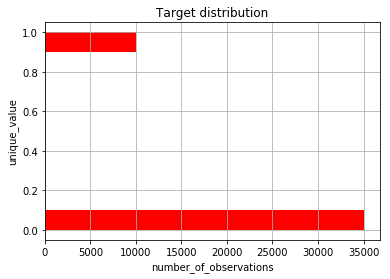

In [5]:
ax =data['SeriousDlqin2yrs'].hist(orientation='horizontal', color='red')
ax.set_xlabel("number_of_observations")
ax.set_ylabel("unique_value")
ax.set_title("Target distribution")

print('Distribution of target')
data['SeriousDlqin2yrs'].value_counts()/data.shape[0]

In [6]:
## Выберем названия всех признаков из таблицы, кроме прогнозируемого

independent_columns_names = data.columns.values
independent_columns_names = [x for x in data if x != 'SeriousDlqin2yrs']
independent_columns_names

['age',
 'NumberOfTime30-59DaysPastDueNotWorse',
 'DebtRatio',
 'NumberOfTimes90DaysLate',
 'NumberOfTime60-89DaysPastDueNotWorse',
 'MonthlyIncome',
 'NumberOfDependents']

In [7]:
## Применяем функцию, заменяющую все NaN значения на медианное значение соответствующего столбца
table =delete_nan(data)

In [8]:
## Разделяем таргет и признаки 
X =table[independent_columns_names]
y = table['SeriousDlqin2yrs']

## Бутстрэп

#### Задание 2. Сделайте интервальную оценку среднего возраста (age) для клиентов, которые просрочили выплату кредита, с 90% "уверенностью". Используйте пример из статьи, поставьте np.random.seed(0), как это сделано в статье.

In [9]:
def get_bootstrap_samples(data, n_samples):
    # функция для генерации подвыборок с помощью бутстрэпа
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples
def stat_intervals(stat, alpha):
    # функция для интервальной оценки
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [10]:
bad_age_est = [np.mean(sample) for sample in get_bootstrap_samples(X.loc[y==0,"age"].values, 1000)]
print("90% interval estimation of the age of credit default: ",  stat_intervals(bad_age_est, 0.1))


90% interval estimation of the age of credit default:  [52.59454006 52.84540486]


------------//-------------

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold

## Используем модуль LogisticRegression для построения логистической регрессии.
## Из-за несбалансированности классов  в таргете добавляем параметр балансировки.
## Используем также параметр random_state=5 для воспроизводимости результатов
lr = LogisticRegression(random_state=5, class_weight= 'balanced')

## Попробуем подобрать лучший коэффициент регуляризации (коэффициент C в логистической регрессии) для модели лог.регрессии.
## Этот параметр необходим для того, чтобы подобрать оптимальную модель, которая не будет переобучена, с одной стороны, 
## и будет хорошо предсказывать значения таргета, с другой.
## Остальные параметры оставляем по умолчанию.
parameters = {'C': (0.0001, 0.001, 0.01, 0.1, 1, 10)}

## Для того, чтобы подобрать коэффициент регуляризации, попробуем для каждого его возможного значения посмотреть 
## значения roc-auc на стрэтифайд кросс-валидации из 5 фолдов с помощью функции StratifiedKFold

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=5)


#### Задание 3. Сделайте GridSearch с метрикой "roc-auc" по параметру C. Какое оптимальное значение параметра С?

In [16]:
lr_m=GridSearchCV(lr,parameters,cv=skf,scoring='roc_auc')
lr_m.fit(X,y)
print("best score:{0:.3f}".format(lr_m.best_score_))
lr_cofs=lr_m.best_estimator_.coef_[0]

best score:0.795


In [17]:
print("best estimator: ",lr_m.best_estimator_)
print("best score:{0:.3f}".format(lr_m.best_score_))
lr_m.cv_results_

best estimator:  LogisticRegression(C=0.001, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=5,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)
best score:0.795


{'mean_fit_time': array([0.11661425, 0.13487148, 0.15093455, 0.14186072, 0.14256535,
        0.15063295]),
 'std_fit_time': array([0.01119961, 0.01386585, 0.01559854, 0.01493294, 0.01336402,
        0.01424039]),
 'mean_score_time': array([0.00200391, 0.0032083 , 0.00481648, 0.00321007, 0.00521884,
        0.0080276 ]),
 'std_score_time': array([0.00400782, 0.00413505, 0.00393266, 0.00349218, 0.00432575,
        0.00401384]),
 'param_C': masked_array(data=[0.0001, 0.001, 0.01, 0.1, 1, 10],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'C': 0.0001},
  {'C': 0.001},
  {'C': 0.01},
  {'C': 0.1},
  {'C': 1},
  {'C': 10}],
 'split0_test_score': array([0.78867909, 0.79501895, 0.79187911, 0.78943922, 0.78904763,
        0.78904635]),
 'split1_test_score': array([0.79339284, 0.79696261, 0.78919699, 0.78641876, 0.78651164,
        0.78627472]),
 'split2_test_score': array([0.79316483, 0.79784779, 0.7927515 , 0.790

------------//-------------

#### Задание 4. Можно ли считать лучшую модель устойчивой? (модель считаем устойчивой, если стандартное отклонение на валидации меньше 0.5%) Сохраните точность лучшей модели, она вам приходится для следующих заданий

In [18]:
lr_m.cv_results_['std_test_score'][1]<0.005

False

No.

------------//-------------

#### Задание 5. Определите самый важный признак. Важность признака определяется абсолютным значением его коэффициента. Так же нужно нормализировать все признаки, что бы можно их было корректно сравнить.



In [19]:
X.columns.values

array(['age', 'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio',
       'NumberOfTimes90DaysLate', 'NumberOfTime60-89DaysPastDueNotWorse',
       'MonthlyIncome', 'NumberOfDependents'], dtype=object)

In [21]:
cofs_norm=lr_cofs.copy()
for ind,i in enumerate(X.columns.values):
    cofs_norm[ind]=(cofs_norm[ind]-X[i].mean())/X[i].std()
t=np.flip(np.argsort(cofs_norm))
cofs_norm

#X.columns[t]

array([-3.49650346, -0.0434381 , -0.14267666, -0.02274349, -0.07148841,
       -0.54564116, -0.58276392])

In [22]:
X_norm = StandardScaler().fit_transform(X)
t=LogisticRegression(C=0.001)
t.fit(X_norm,y)
cofs_norm=t.coef_[0]
ind=np.flip(np.argsort(cofs_norm))
X.columns.values[ind[0]]

'NumberOfTime30-59DaysPastDueNotWorse'

------------//-------------

#### Задание 6. Посчитайте долю влияния DebtRatio на предсказание. (Воспользуйтесь функцией softmax)

In [23]:
def softmax(x,cofs):
    t=cofs.copy()
    k=np.power(np.e, cofs*x)
    for ind, i in enumerate(k):
        t[ind]=i/k.sum()
    return t

In [24]:
t=X.apply(lambda x: softmax(x.values,lr_cofs),axis=1)
t

0        [0.05018051168784283, 0.1606912401162013, 0.16...
1        [0.055725559141773254, 0.1600018289477946, 0.1...
2        [0.07412170415124161, 0.15622619712723093, 0.1...
3        [0.06927965390395058, 0.15142922854955942, 0.1...
4        [0.0640393284972713, 0.15611239067617497, 0.15...
5        [0.05865627545439193, 0.15947466282767783, 0.1...
6        [0.09602119378676499, 0.15129037081377467, 0.1...
7        [0.08723474548611274, 0.15329228196071112, 0.1...
8        [0.06334188226908541, 0.32574036453745836, 0.1...
9        [0.05814446748432632, 0.15808315948338186, 0.1...
10       [0.0028799285392132235, 0.9392462603753399, 0....
11       [0.057322612933268915, 0.16162134750501153, 0....
12       [0.009284976098082784, 0.894636455341717, 0.01...
13       [0.05163647369155032, 0.1565742682622329, 0.15...
14       [0.039203841928339506, 0.1619401326412774, 0.1...
15       [0.05328558388750333, 0.15299605800026017, 0.1...
16       [0.08851906890602365, 0.1527460051326426, 0.15.

In [25]:
ind=np.where(X.columns.values=="DebtRatio")
debt_imp=np.asarray([i[ind] for i in t]).flatten()
t=debt_imp.mean()
print("Fraction of influence for DebtRatio: {0:.3f}".format(t))

Fraction of influence for DebtRatio: 0.146


------------//-------------

#### Задание 7. Давайте посмотрим как можно интерпретировать влияние наших признаков. Для этого заного оценим логистическую регрессию в абсолютных величинах. После этого посчитайте во сколько раз увеличатся шансы, что клиент не выплатит кредит, если увеличить возраст на 20 лет при всех остальных равных значениях признаков. (теоретический расчет можно посмотреть здесь)

In [26]:
def odds(cofs,x):
    return(np.power(np.e,x*cofs).sum())

In [27]:
odds_regul=X.apply(lambda x: odds(x.values,lr_cofs),axis=1)
odds_regul

0          6.223115
1          6.249929
2          6.400975
3          6.603745
4          6.405641
5          6.270589
6          6.609806
7          6.523486
8          8.055484
9          6.325785
10       132.445319
11         6.187301
12        52.991508
13         6.386745
14         6.175122
15         6.536116
16         6.546816
17         6.554481
18         6.359117
19         6.619716
20         6.305545
21         6.191124
22         6.630322
23         6.489819
24         6.574402
25         9.645127
26         6.163935
27         6.215292
28         5.981540
29        16.941234
            ...    
45033      6.567329
45034      6.266911
45035      6.435459
45036      6.261360
45037      6.336399
45038      8.198026
45039      6.595404
45040      6.992173
45041      6.337681
45042      6.304057
45043      6.217281
45044      6.653172
45045      6.345500
45046      6.527002
45047      7.156522
45048      6.720659
45049      6.181703
45050      6.328346
45051      7.121502


In [33]:
X_age=X.copy()
X_age["age"]=X_age["age"]+20
odds_age=X_age.apply(lambda x: odds(x.values,lr_cofs),axis=1)
t=odds_age/odds_regul
print("quotient of odds with increased age and regular odds: {0:.3f}".format(t.mean()))

quotient of odds with increased age and regular odds: 0.982


------------//-------------

## Случайный лес

In [34]:
# Инициализируем случайный лес с 100 деревьями и сбалансированными классами 
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1, 
                            random_state=42, oob_score=True, 
                            class_weight='balanced')

## Будем искать лучшие параметры среди следующего набора
parameters = {'max_features': [1, 2, 4], 
              'min_samples_leaf': [3, 5, 7, 9], 
              'max_depth': [5,10,15]}

## Делаем опять же стрэтифайд k-fold валидацию. Инициализация которой должна у вас продолжать храниться в skf

#### Задание 8. На сколько точность лучшей модели случайного леса выше точности логистической регрессии на валидации?

In [42]:
skf= StratifiedKFold(n_splits=3, shuffle=False, random_state=42)
gcv = GridSearchCV(rf, parameters, n_jobs=-1, cv=skf, verbose=1)
gcv.fit(X, y)


Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   18.1s
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:   54.8s finished


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=False),
       error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=-1, oob_score=True, random_state=42,
            verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'max_features': [1, 2, 4], 'min_samples_leaf': [3, 5, 7, 9], 'max_depth': [5, 10, 15]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [46]:
rf_est=gcv.best_estimator_ 
rf_pred=rf_est.predict(X)
log_pred=lr_m.best_estimator_.predict(X)
rf_acc=accuracy_score(y,rf_pred)
log_acc=accuracy_score(y,log_pred)
print("Log Regression accuracy: {0:.3f}".format(log_acc))
print("Random forest accuracy: {0:.3f}".format(rf_acc))

Log Regression accuracy: 0.803
Random forest accuracy: 0.862


------------//-------------

#### Задание 9. Определите какой признак имеет самое слабое влияние.



In [53]:
rf_imps=rf_est.feature_importances_
print(rf_imps)
ind=np.argsort(rf_imps)[0]
print(X.columns.values[ind])

[0.14710464 0.21780516 0.16992599 0.19753667 0.11279971 0.12818763
 0.0266402 ]
NumberOfDependents


#### Задание 10. Какое наиболее существенное примущество логистической регрессии перед случайным лесом для нашей бизнес-задачи?



меньше тратится времени для тренировки модели;
меньше параметров для перебора;
интепретируемость признаков;
линейные свойства алгоритма.

In [ ]:
#интепретируемость признаков

## Бэггинг

In [57]:
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import RandomizedSearchCV
parameters = {'max_features': [2, 3, 4], 'max_samples': [0.5, 0.7, 0.9], 
              "base_estimator__C": [0.0001, 0.001, 0.01, 1, 10, 100]}

#### Задание 11. 
Следующая задача обучить бэггинг классификатор (random_state=42). В качестве базовых классификаторов возьмите 100 логистических регрессий и на этот раз используйте не GridSearchCV, а RandomizedSearchCV. Так как перебирать все 54 варианта комбинаций долго, то поставьте максимальное число итераций 20 для RandomizedSearchCV. Также не забудьте передать параметр валидации cv и random_state=1. Какая лучшая точность получилась?



In [63]:
bc=BaggingClassifier(base_estimator=lr_m.best_estimator_, n_estimators=100)
rcv=RandomizedSearchCV(bc, parameters, n_jobs=-1, cv=skf, verbose=1, n_iter=20, randomstate=1)
rcv.fit(X,y)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=False),
          error_score='raise-deprecating',
          estimator=BaggingClassifier(base_estimator=LogisticRegression(C=0.001, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=5,
          solver='warn', tol=0.0001, verbose=0, warm_s...timators=100, n_jobs=None, oob_score=False,
         random_state=None, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=20, n_jobs=-1,
          param_distributions={'max_features': [2, 3, 4], 'max_samples': [0.5, 0.7, 0.9], 'base_estimator__C': [0.0001, 0.001, 0.01, 1, 10, 100]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=0)

In [64]:
rcv_est=rcv.best_estimator_
rcv_pred=rcv.predict(X)
rcv_acc=accuracy_score(y,rcv_pred)
print(rcv_acc)

0.8143488005680936


#### Задача 12. Дайте интерпретацию лучших параметров для бэггинга. Почему именно такие значения оказались лучшими?



In [66]:
rcv.best_params_

{'max_samples': 0.5, 'max_features': 4, 'base_estimator__C': 0.0001}